# Datathon #6 - Classification

This week, you will train a set of classifiers to label LEGO sets by theme, based on other metadata about the sets (year, number of parts, colors, or some combination of them). 

You should test at least 5 different classifiers:
+ kNN
+ Naïve Bayes
+ Decision Tree
+ Random Forest
+ Neural Network


For each classifier, report:
1. What parameters (if any) you tuned.
2. How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
3. Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

We will use a variant of the second dataset from last week, adding a "theme" column.

** LEGO Colors by Set + Theme** — Contains data on the colors of the pieces in each LEGO set.

- Set Num = A unique alphanumeric ID number for each set. 
- Set Name = The official name of the set (some names are reused for more than one set).
- Year = The year the set was released.
- Num Parts = Total number of parts listed on the box.
- Theme = The theme the set was released under ("Technic", "Ninjago", "Star Wars", "City", etc.)
- [Colors] = Number of parts of each color in the set, according to the Rebrickable database.

You can also get more data about individual sets by going to http://rebrickable.com/sets/{SetNum}

In [2]:
# Import data, remove NaN
lego_frame_full = pd.read_excel('Set Color Data+Themes.xlsx')
lego_frame_full.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 most popular themes.
lego_frame = lego_frame_full[(lego_frame_full["Theme"] == "Technic") | 
                        (lego_frame_full["Theme"] == "Friends") |
                        (lego_frame_full["Theme"] == "City") |
                        (lego_frame_full["Theme"] == "Basic Set") |
                        (lego_frame_full["Theme"] == "Creator") |
                        (lego_frame_full["Theme"] == "Duplo") |
                        (lego_frame_full["Theme"] == "Star Wars") |
                        (lego_frame_full["Theme"] == "Ninjago") |
                        (lego_frame_full["Theme"] == "Construction") |
                        (lego_frame_full["Theme"] == "Airport")]

In [3]:
lego_frame.head(20)

,Set Num,Set Name,Theme,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
4,2823692,Simple and Motorized Machines Activity Pack,Technic,1997,24,24.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2818944,Structures Set,Technic,1997,439,20.0,0.0,116.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2814926,Technology Activity Set,Technic,1994,318,17.0,0.0,92.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
11,2815291,Teacher's Guide for Technology Group Activity Set,Technic,1994,16,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,951-2,Lego TC logo Starter Pack,Technic,1988,16,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,130394,Spinjitzu Starter Set,Ninjago,2011,47,12.0,0.0,12.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,0.0
15,226452,Battle Arena,Ninjago,2011,462,11.0,0.0,132.0,21.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,1.0,0.0
20,2759774,Spinner Battle Arena,Ninjago,2012,408,10.0,0.0,65.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,0.0
21,2804699,Starter Set,Ninjago,2012,53,10.0,0.0,13.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,2809082,Weapon Pack,Ninjago,2012,73,10.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Some potentially useful refactorings of the data.

In [4]:
# Creates a copy of the dataframe where color counts are normalized 
#  so each gives the % of parts in the set with that color, rather than the total count.
norm_lego = lego_frame.copy()
norm_lego = norm_lego.drop([ 'Set Name', 'Set Num', 'Theme', 'Year', 'Num Parts'], axis=1)
norm_lego = norm_lego.div(norm_lego.sum(axis=1), axis=0)

# A list of all the color name columns
color_cols = norm_lego.columns
# A list of all the other numeric columns
other_cols = ["Year", "Num Parts"]

# Add back the non-numeric columns to the normalized table
norm_lego["Year"] = lego_frame["Year"]
norm_lego["Set Name"] = lego_frame["Set Name"]
norm_lego["Set Num"] = lego_frame["Set Num"]
norm_lego["Theme"] = lego_frame["Theme"]
norm_lego["Num Parts"] = lego_frame["Num Parts"]
norm_lego.head(3)

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,Very Light Orange,Violet,White,Yellow,Yellowish Green,Year,Set Name,Set Num,Theme,Num Parts
4,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Simple and Motorized Machines Activity Pack,2823692,Technic,24
8,0.045558,0.0,0.264237,0.127563,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Structures Set,2818944,Technic,439
10,0.051360,0.0,0.277946,0.006042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006042,0.003021,0.0,1994,Technology Activity Set,2814926,Technic,318


In [5]:
color_cols # The complete list of color columns

Index(['[No Color]', 'Aqua', 'Black', 'Blue', 'Blue-Violet', 'Bright Green',
       'Bright Light Blue', 'Bright Light Orange', 'Bright Light Yellow',
       'Bright Pink',
       ...
       'Trans-Very Lt Blue', 'Trans-Yellow', 'Unknown',
       'Very Light Bluish Gray', 'Very Light Gray', 'Very Light Orange',
       'Violet', 'White', 'Yellow', 'Yellowish Green'],
      dtype='object', length=131)

## Training and Test Splits
Make sure you don't accidentally test on your training data.

In [6]:
# Generate test and training sets
from sklearn.model_selection import train_test_split

# TODO: Make sure you split your data into training and test sets before you start training classifiers.

## k-Nearest Neighbors

In [7]:
#

In [8]:
#lego_knn_predictions = lego_knn.predict(YOUR_TEST_INPUTS) #TODO — substitute in your own test data

## Naive Bayes

Accuracy:   0.4707112970711297
Precision:  0.5558622690462541
Recall:     0.4707112970711297
F1 Score:   0.44445883202578174


Text(0.5,1,'Confusion Matrix')

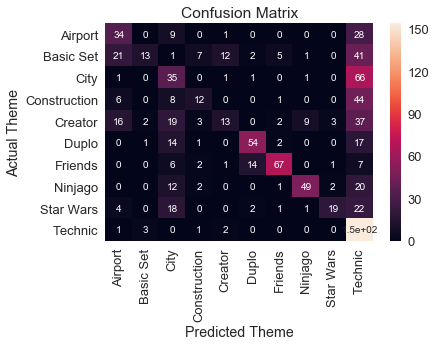

In [9]:
# Import Naive Bayes Classification and training.
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Import data, remove NaN
nbFrameFull = pd.read_excel('Set Color Data+Themes.xlsx')
nbFrameFull.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 most popular themes.
nbFrame = nbFrameFull[(nbFrameFull["Theme"] == "Technic") | (nbFrameFull["Theme"] == "Friends") | 
                      (nbFrameFull["Theme"] == "City") | (nbFrameFull["Theme"] == "Basic Set") |
                      (nbFrameFull["Theme"] == "Creator") | (nbFrameFull["Theme"] == "Duplo") |
                      (nbFrameFull["Theme"] == "Star Wars") | (nbFrameFull["Theme"] == "Ninjago") |
                      (nbFrameFull["Theme"] == "Construction") | (nbFrameFull["Theme"] == "Airport")]

## Tests/Trains with the specified values. (Top 3 colors of each set excluding top 10 overall colors.)
nbList = ['Year','Trans-Light Blue', 'Trans-Black', 'Trans-Red', 'Orange', 'Lime', 'Trans-Clear', 
          'Trans-Orange', 'Reddish Brown', 'Dark Green','Bright Green', 'Medium Azure', 'Magenta', 
          'Pearl Gold', 'Dark Tan', 'Flat Silver', 'Dark Red', 'Dark Gray']

## Uses every color available.
nbList = color_cols

## Prepare for testing/training.
nbGNB = GaussianNB().fit(nbFrame[nbList], nbFrame['Theme'])
nbGNBP = nbGNB.predict(nbFrame[nbList])

## Trains with 60% of the data, and leaves 40% for testing.
list_train, list_test, theme_train, theme_test = sk.model_selection.train_test_split(
    nbFrame[nbList],nbFrame['Theme'], test_size=0.4, random_state=0)

## Tests with 40% of the data.
nbGNBT = GaussianNB().fit(list_train,theme_train)
nbGNBPT = nbGNB.predict(list_test)

## Print results.
print("Accuracy:  ", skm.accuracy_score(y_true=theme_test, y_pred=nbGNBPT))
print("Precision: ", skm.precision_score(y_true=theme_test, y_pred=nbGNBPT, average='weighted'))
print("Recall:    ", skm.recall_score(y_true=theme_test, y_pred=nbGNBPT,average='weighted'))
print("F1 Score:  ", skm.f1_score(y_true=theme_test, y_pred=nbGNBPT, average='weighted'))

## Calculate and visualize confusion matrix.
nbMat = skm.confusion_matrix(y_true=theme_test, y_pred=nbGNBPT)
sns.heatmap(nbMat, xticklabels=nbGNBT.classes_, yticklabels=nbGNBT.classes_, annot=True)
plt.xlabel('Predicted Theme')
plt.ylabel('Actual Theme')
plt.title('Confusion Matrix')

## Decision Trees

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
#TODO — Train and test

#### Drawing a Decision Tree
Rendering decision trees requires the graphviz package. You can install it from the terminal or command line using:
> conda install python-graphviz

In [12]:
import graphviz 
graph_data = sk.tree.export_graphviz(YOUR_CLASSIFIER, out_file=None,
                         feature_names=YOUR_FEATURE_NAMES,  
                         class_names=YOUR_CLASS_NAMES,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(graph_data) 
graph

# Or save out to a file using this command:
# graph.render("decision_tree") 

ModuleNotFoundError: No module named 'graphviz'

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#TODO — Train and test

## Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
#TODO — Train and test